In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm
import cv2
import os
import seaborn as sns
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, Reshape, Input, Conv2DTranspose
from keras.layers import Activation, LeakyReLU, BatchNormalization, Dropout, Resizing
from keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import VGG16

import warnings
warnings.filterwarnings('ignore')

try:
    from tensorflow.keras.optimizers import Adam
except:
    from keras.optimizers import Adam

In [3]:
NOISE_DIM = 100  
BATCH_SIZE = 4 
STEPS_PER_EPOCH = 3750
EPOCHS = 10
SEED = 40
WIDTH, HEIGHT, CHANNELS = 128, 128, 1

OPTIMIZER = Adam(0.0002, 0.5)

In [4]:
MAIN_DIR = "../input/brain-mri-images-for-brain-tumor-detection/yes"

In [5]:
def load_images(folder):
    
    imgs = []
    target = 1
    labels = []
    for i in os.listdir(folder):
        img_dir = os.path.join(folder,i)
        try:
            img = cv2.imread(img_dir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (128,128))
            imgs.append(img)
            labels.append(target)
        except:
            continue
        
    imgs = np.array(imgs)
    labels = np.array(labels)
    
    return imgs, labels

In [6]:
data, labels = load_images(MAIN_DIR)
data.shape, labels.shape

((155, 128, 128), (155,))

In [7]:
np.random.seed(SEED)
idxs = np.random.randint(0, 155, 124)

In [8]:
X_train = data[idxs]
X_train.shape

(20, 128, 128)

In [9]:
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
 
X_train = X_train.reshape(-1, WIDTH,HEIGHT,CHANNELS)

X_train.shape

(20, 128, 128, 1)

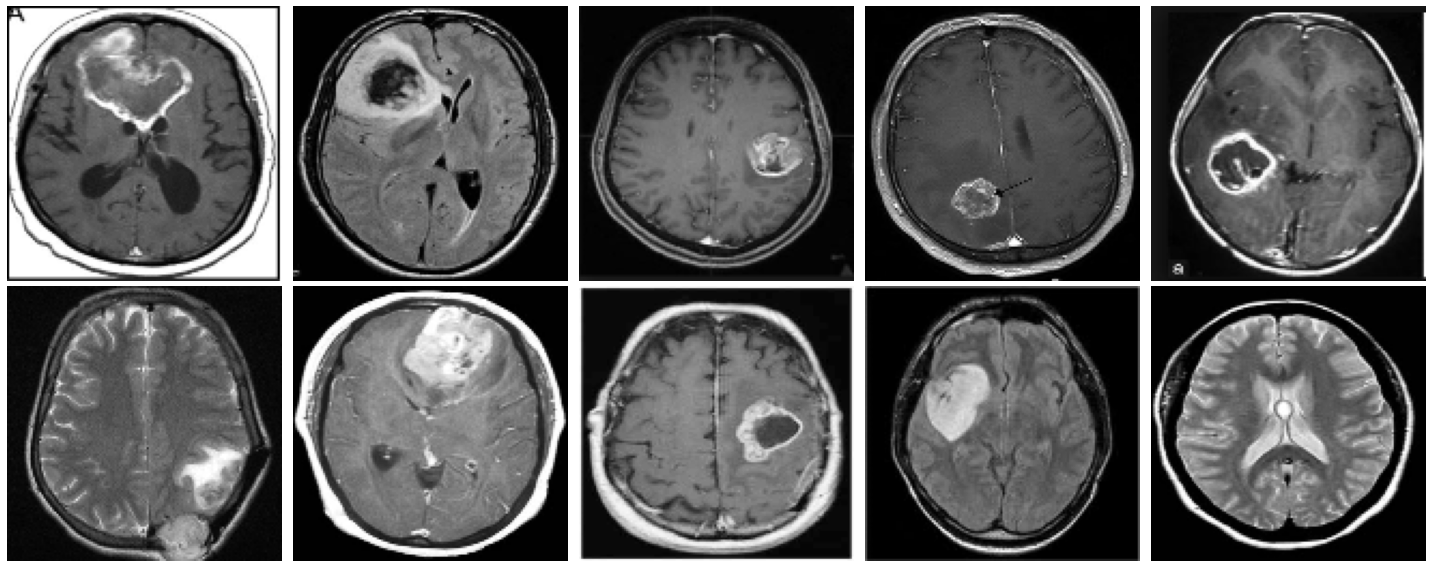

In [10]:
plt.figure(figsize=(20,8))
for i in range(10):
    axs = plt.subplot(2,5,i+1)
    plt.imshow(X_train[i], cmap="gray")
    plt.axis('off')
    axs.set_xticklabels([])
    axs.set_yticklabels([])
    plt.subplots_adjust(wspace=None, hspace=None)
plt.tight_layout()

In [17]:
from keras.layers import Input, Dense, Reshape, Conv2D, Conv2DTranspose, LeakyReLU
from keras.models import Model

def build_generator():
    noise = Input(shape=(NOISE_DIM,))
    
    x = Dense(128*128*256)(noise)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((128, 128, 256))(x)
    
    x = Conv2D(512, (3, 3), strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(256, (3, 3), strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(128, (3, 3), strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2DTranspose(128, (2, 2), strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2DTranspose(256, (2, 2), strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2DTranspose(512, (2, 2), strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    output = Conv2D(CHANNELS, (4, 4), padding='same', activation='tanh')(x)
    
    model = Model(inputs=noise, outputs=output, name="generator")
    model.summary()
    model.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)
    
    return model

In [18]:
def build_discriminator():
    
    model = Sequential([

        Conv2D(64, (3, 3), padding='same', input_shape=(WIDTH, HEIGHT, CHANNELS)),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        
        Conv2D(256, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        
        Flatten(),
        Dropout(0.4),
        Dense(1, activation="sigmoid", input_shape=(WIDTH, HEIGHT, CHANNELS))
    ], name="discriminator")
    model.summary()
    model.compile(loss="binary_crossentropy",
                        optimizer=OPTIMIZER)

    return model

In [19]:
print('\n')
discriminator = build_discriminator()
print('\n')
generator = build_generator()

discriminator.trainable = False 

gan_input = Input(shape=(NOISE_DIM,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output, name="gan_model")
gan.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)

print("The Combined Network:\n")
gan.summary()



Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 128, 128, 64)      640       
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 256)   

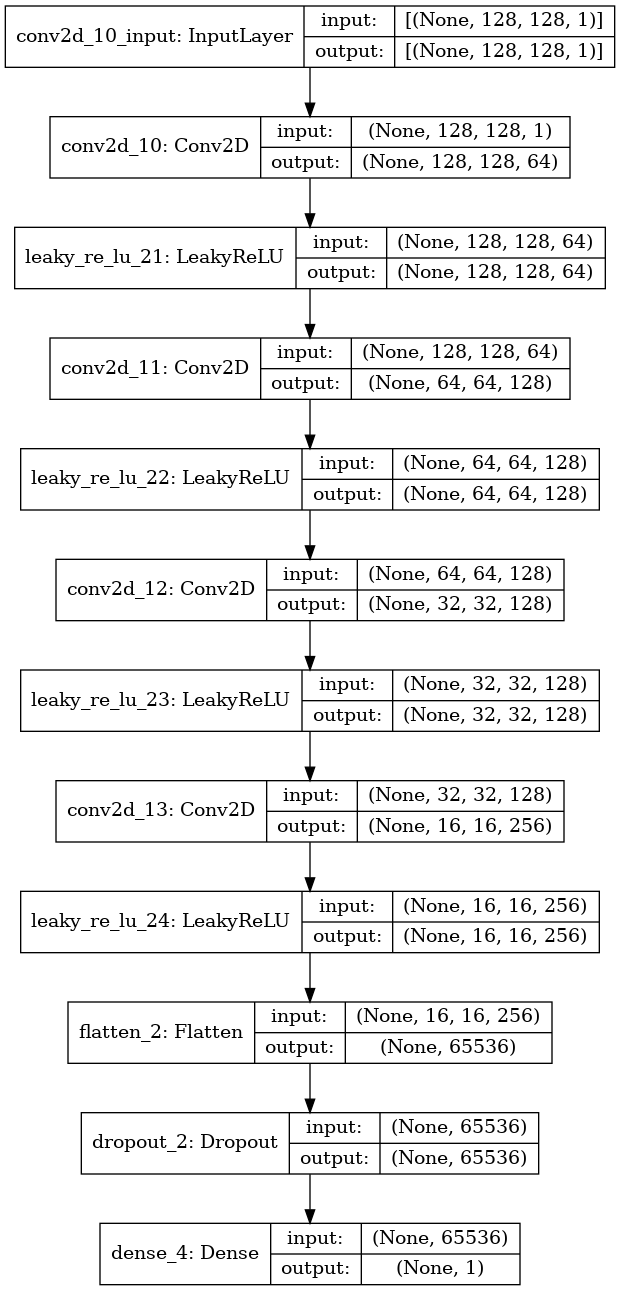

In [23]:
from keras.utils.vis_utils import plot_model

plot_model(discriminator, to_file='disc.png', show_shapes=True, show_layer_names=True)


In [24]:
def sample_images(noise, subplots, figsize=(22,8), save=False):
    generated_images = generator.predict(noise)
    plt.figure(figsize=figsize)
    
    for i, image in enumerate(generated_images):
        plt.subplot(subplots[0], subplots[1], i+1)
        if CHANNELS == 1:
            plt.imshow(image.reshape((WIDTH, HEIGHT)), cmap='gray')    
                                                                            
        else:
            plt.imshow(image.reshape((WIDTH, HEIGHT, CHANNELS)))
        if save == True:
            img_name = "gen" + str(i)
            plt.savefig(img_name)
        plt.subplots_adjust(wspace=None, hspace=None)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

100%|██████████| 3750/3750 [11:58<00:00,  5.22it/s]


EPOCH: 1 Generator Loss: 3.7955 Discriminator Loss: 0.1832


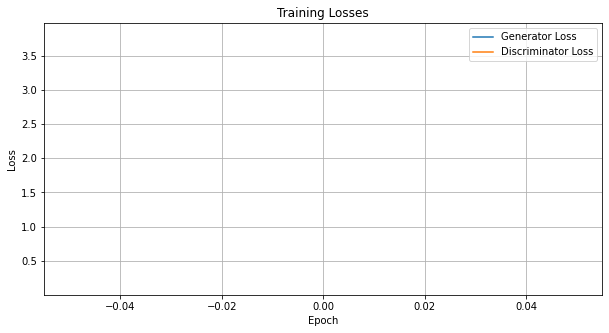

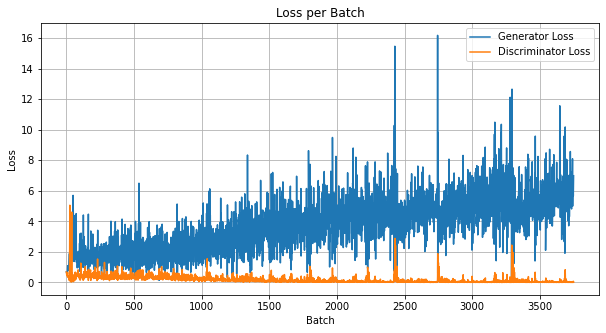

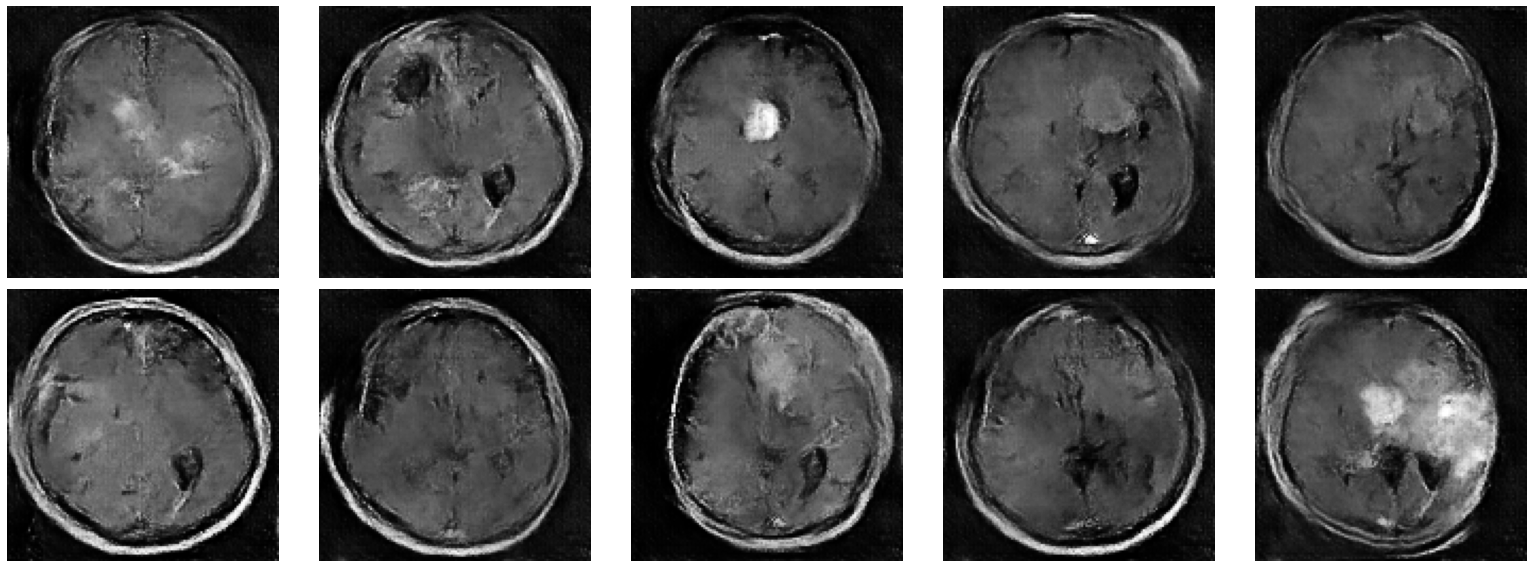

100%|██████████| 3750/3750 [11:44<00:00,  5.32it/s]


EPOCH: 2 Generator Loss: 5.9394 Discriminator Loss: 0.0818
Pesos guardados


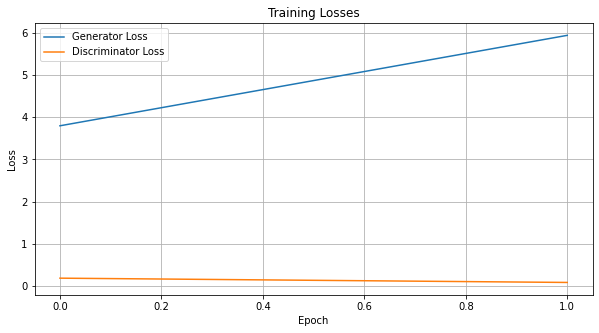

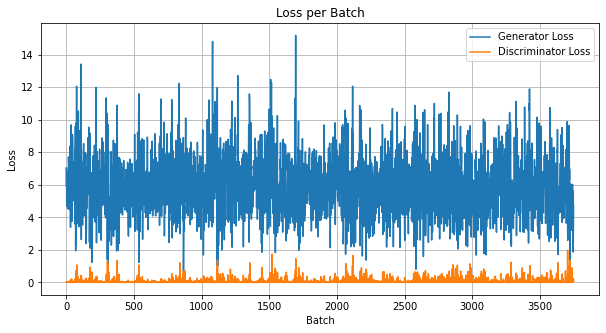

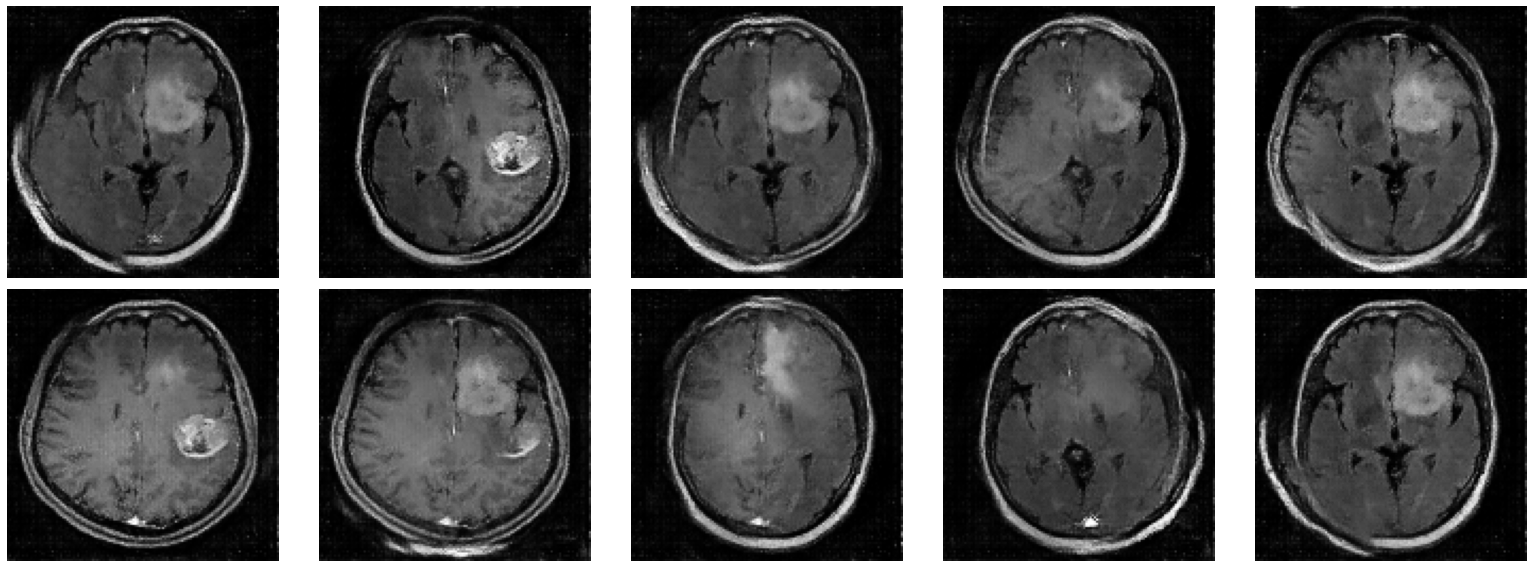

100%|██████████| 3750/3750 [11:34<00:00,  5.40it/s]


EPOCH: 3 Generator Loss: 5.1085 Discriminator Loss: 0.1114


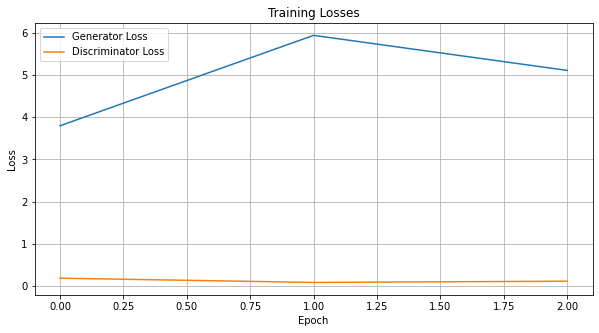

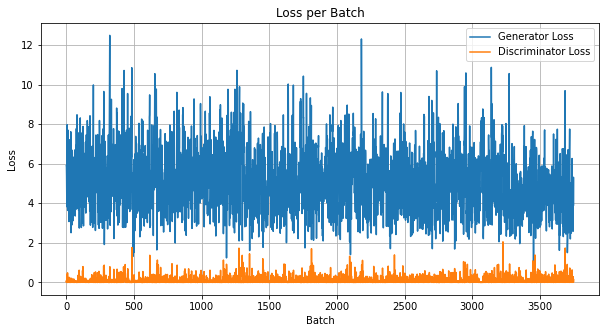

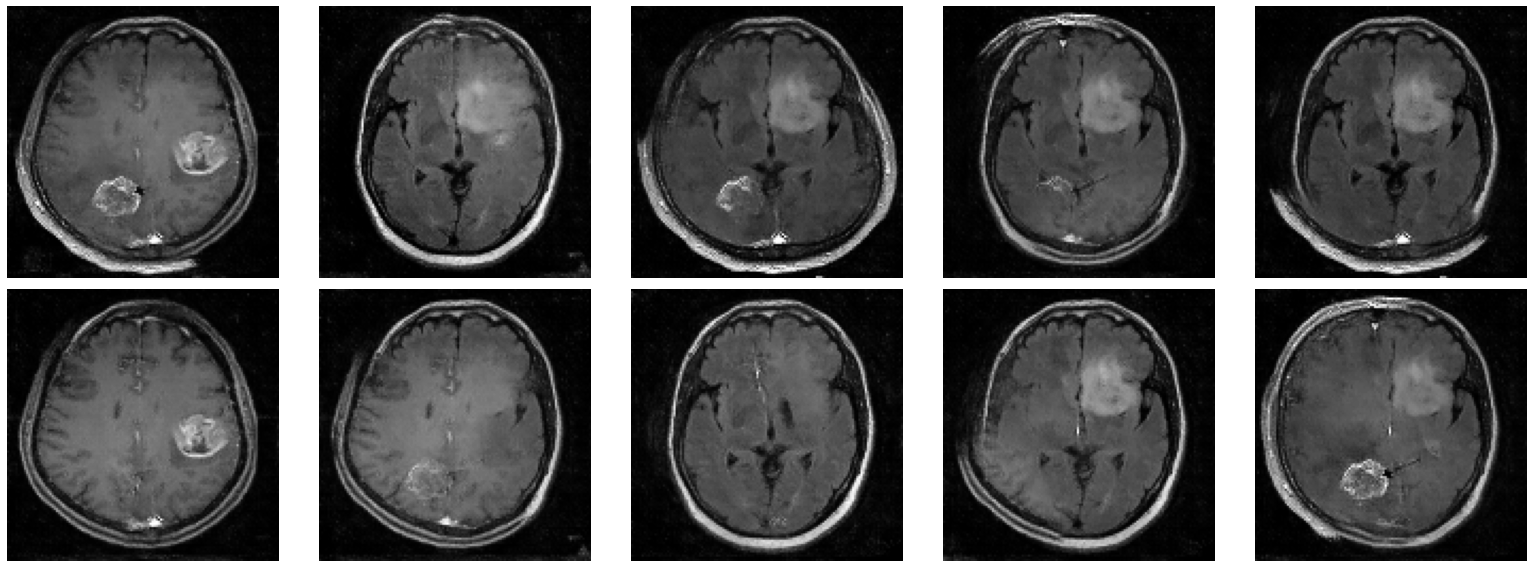

100%|██████████| 3750/3750 [11:33<00:00,  5.41it/s]


EPOCH: 4 Generator Loss: 4.2093 Discriminator Loss: 0.1360
Pesos guardados


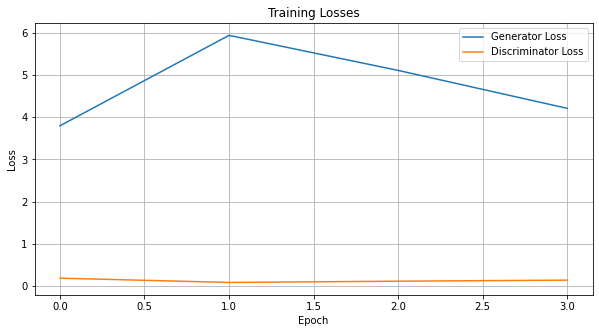

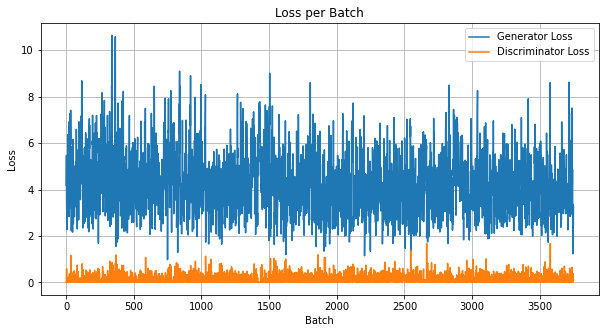

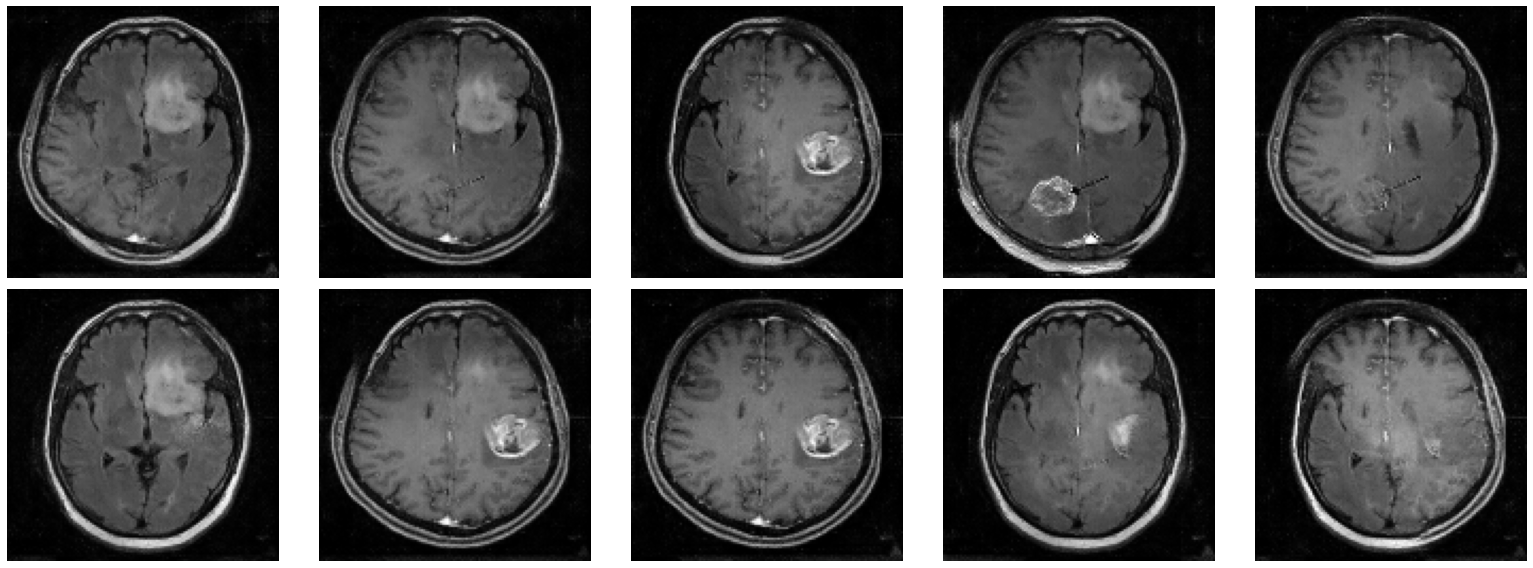

100%|██████████| 3750/3750 [11:32<00:00,  5.41it/s]


EPOCH: 5 Generator Loss: 3.7970 Discriminator Loss: 0.1431


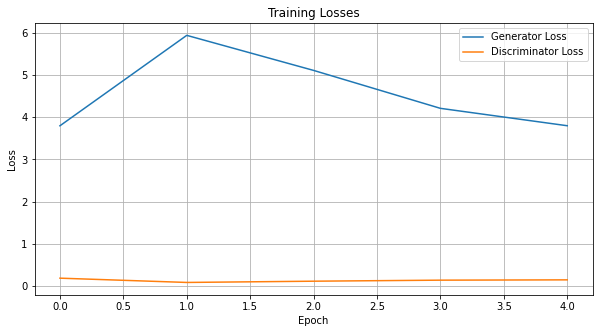

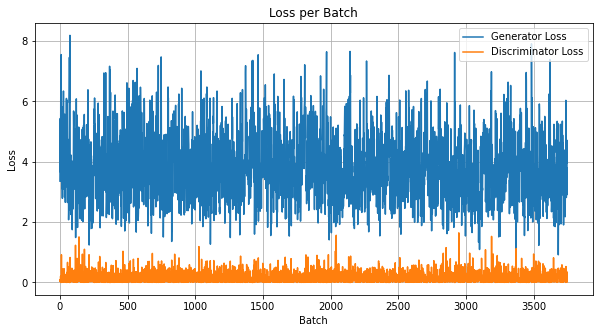

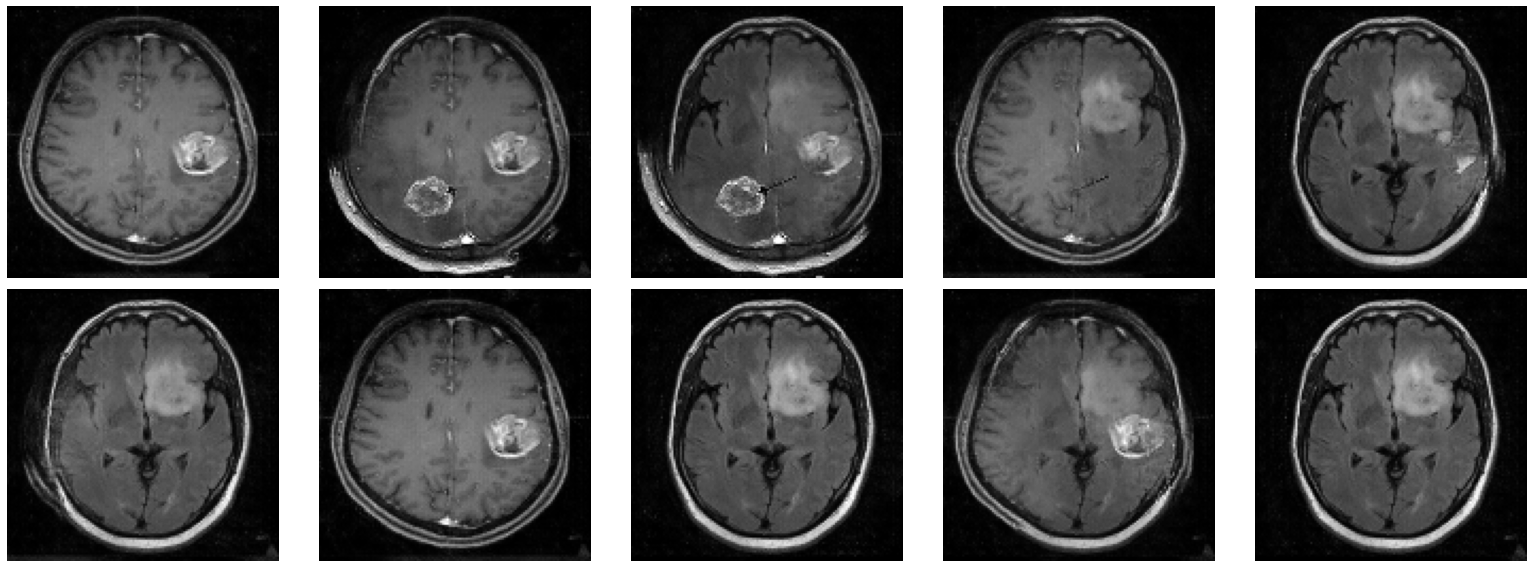

100%|██████████| 3750/3750 [11:38<00:00,  5.37it/s]


EPOCH: 6 Generator Loss: 3.3268 Discriminator Loss: 0.1546
Pesos guardados


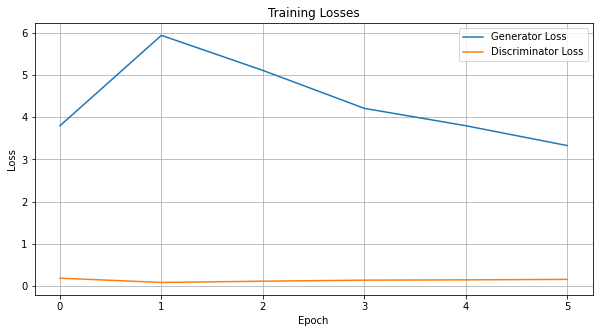

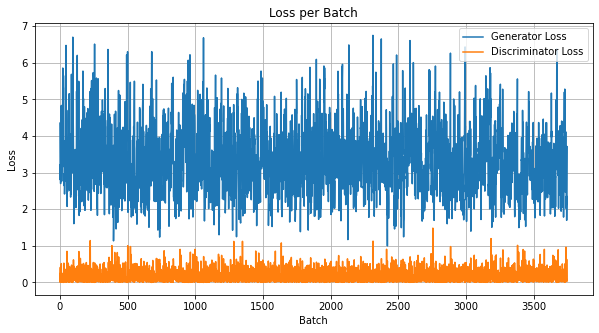

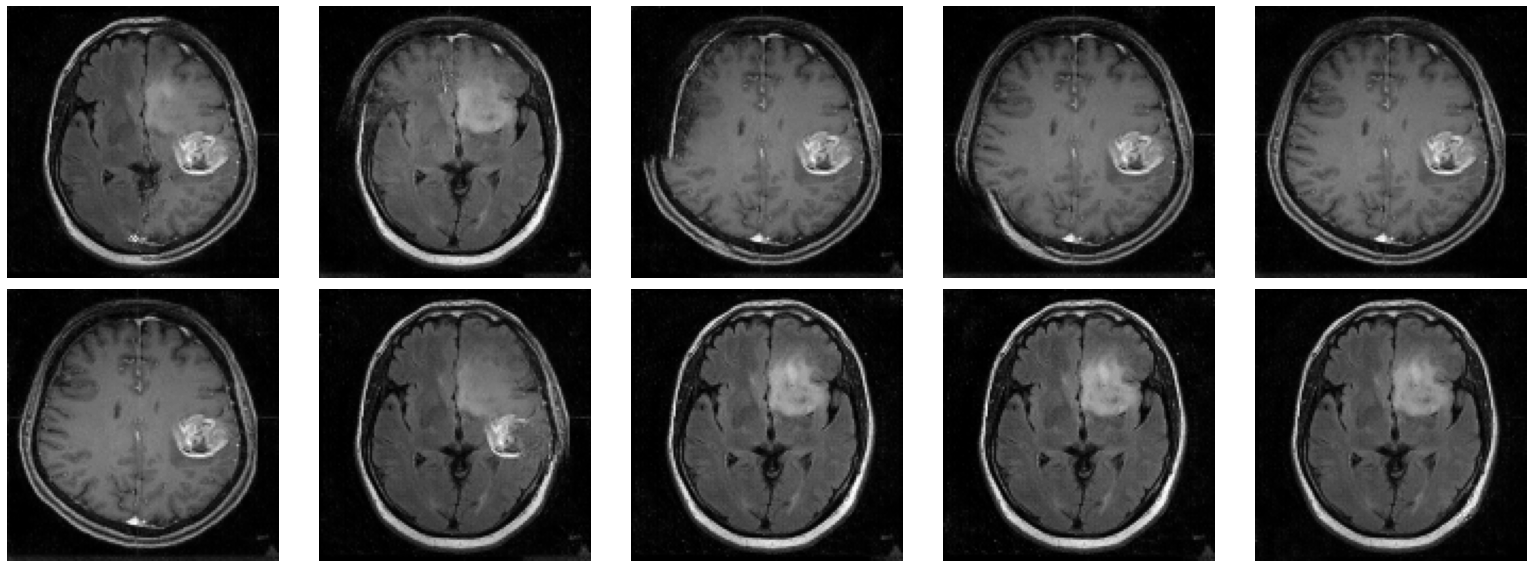

100%|██████████| 3750/3750 [11:35<00:00,  5.39it/s]


EPOCH: 7 Generator Loss: 3.0875 Discriminator Loss: 0.1568


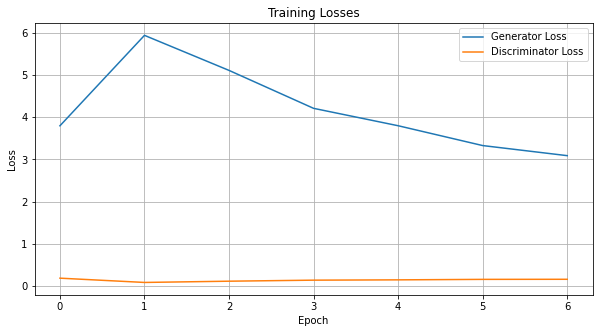

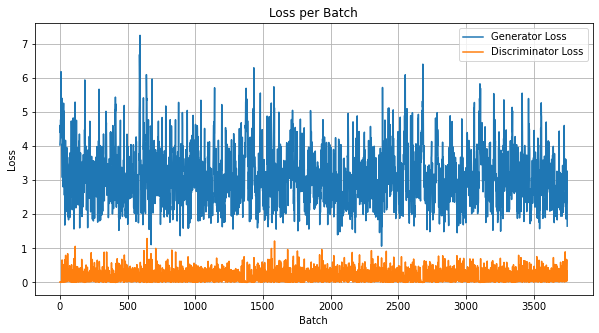

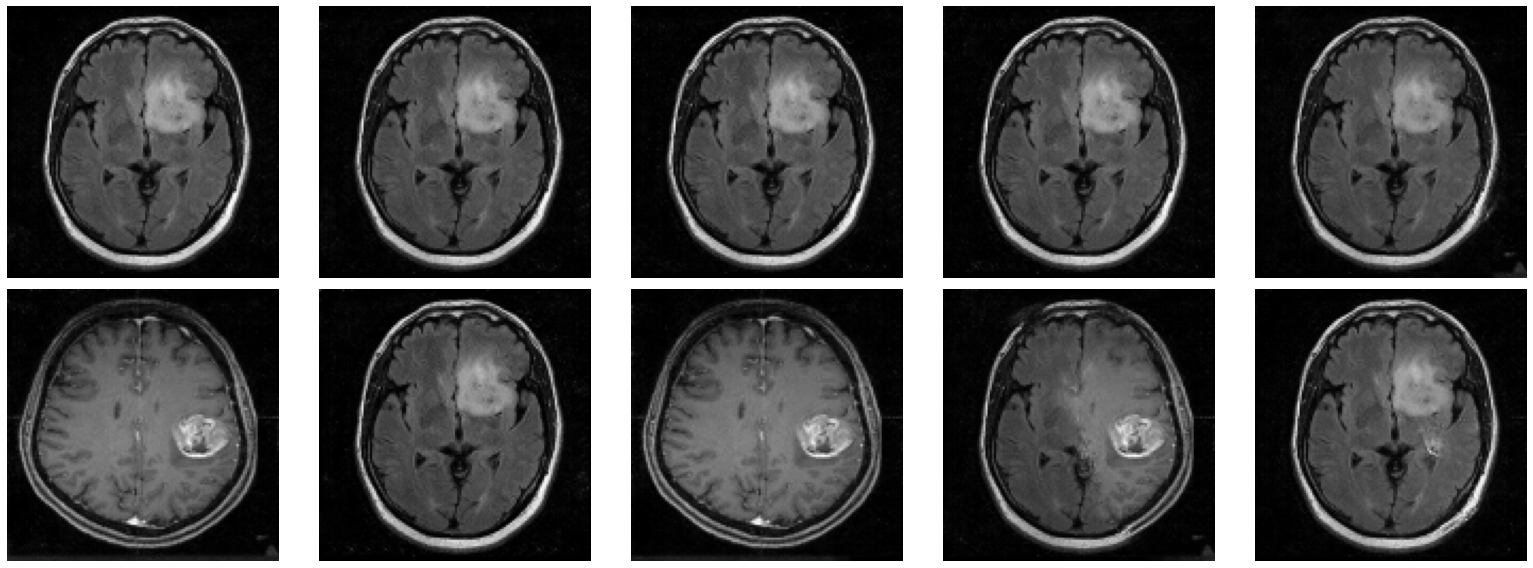

100%|██████████| 3750/3750 [11:40<00:00,  5.35it/s]


EPOCH: 8 Generator Loss: 5.1445 Discriminator Loss: 0.1106
Pesos guardados


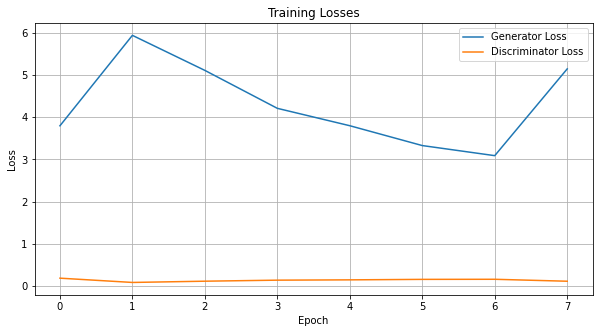

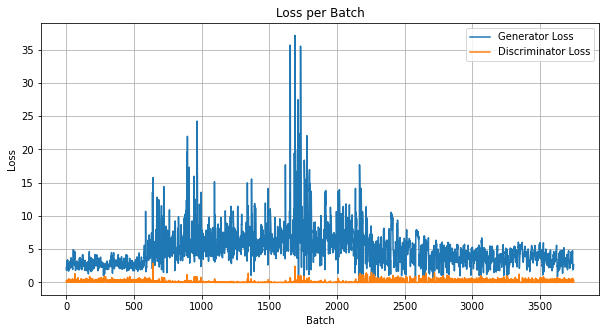

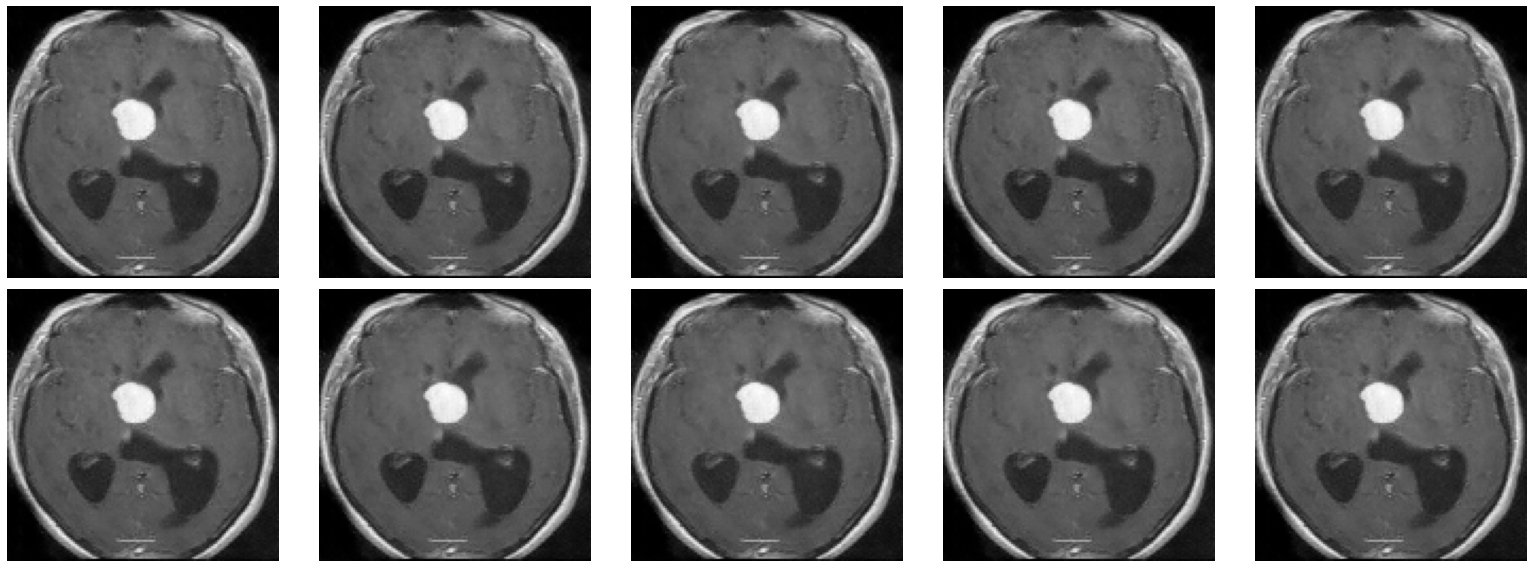

100%|██████████| 3750/3750 [11:47<00:00,  5.30it/s]


EPOCH: 9 Generator Loss: 3.3869 Discriminator Loss: 0.1109


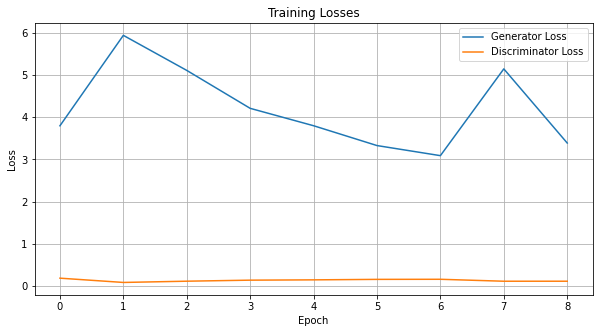

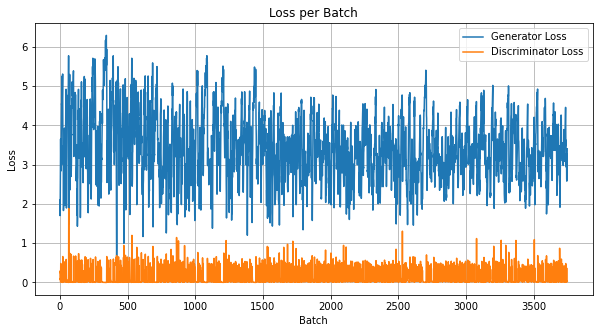

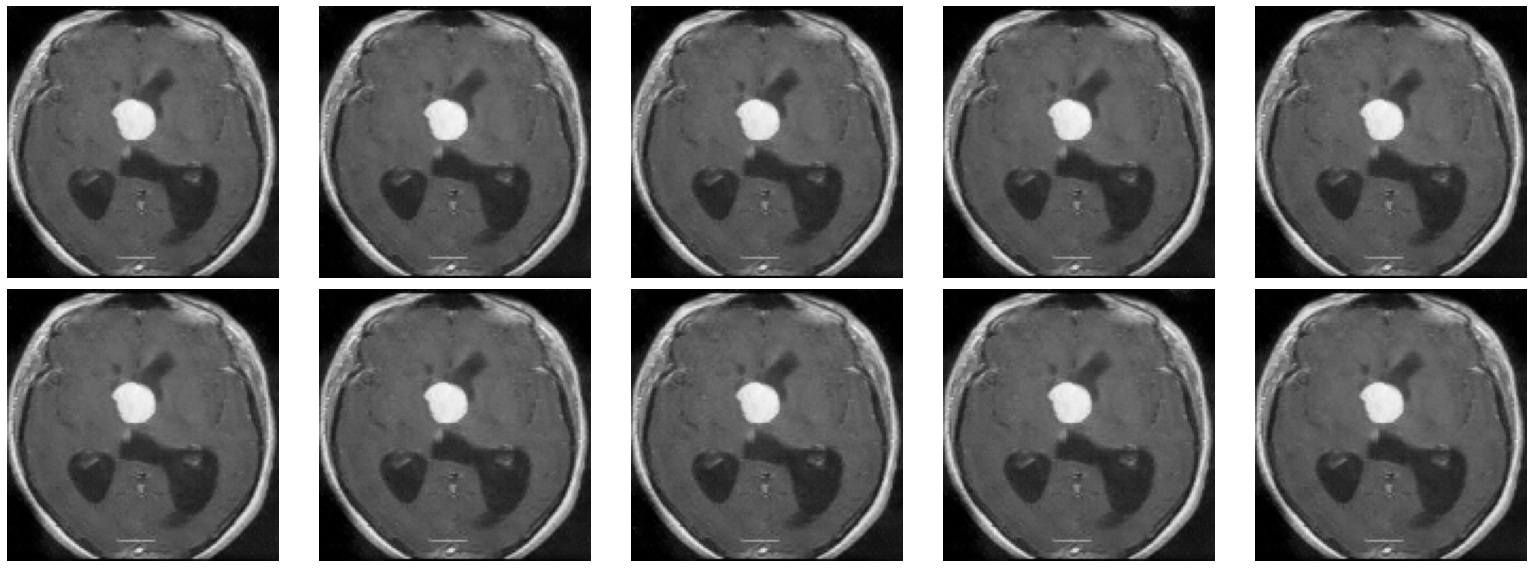

100%|██████████| 3750/3750 [11:47<00:00,  5.30it/s]


EPOCH: 10 Generator Loss: 3.2690 Discriminator Loss: 0.1069
Pesos guardados


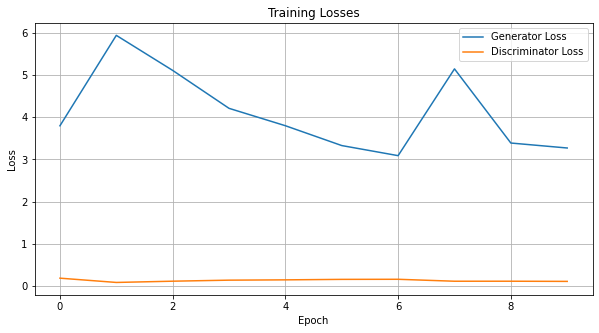

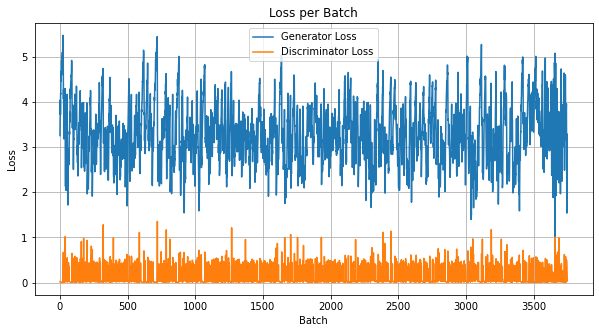

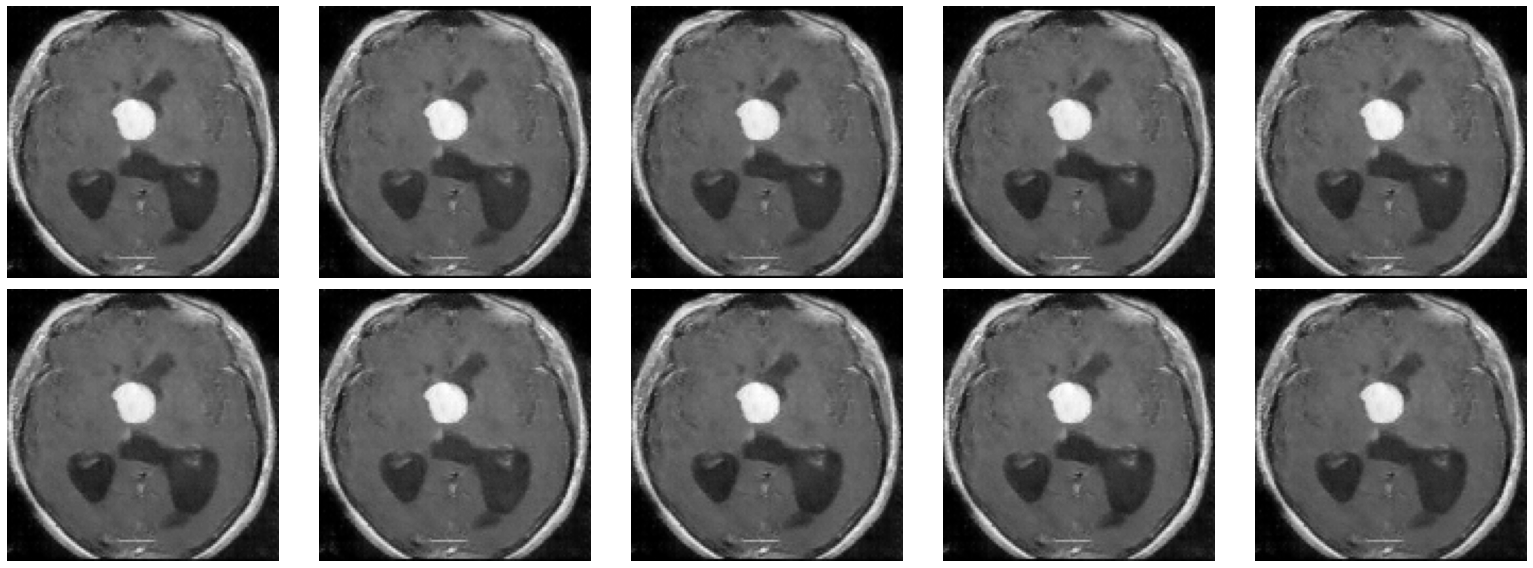

100%|██████████| 3750/3750 [11:44<00:00,  5.32it/s]


EPOCH: 11 Generator Loss: 9.5675 Discriminator Loss: 0.0495


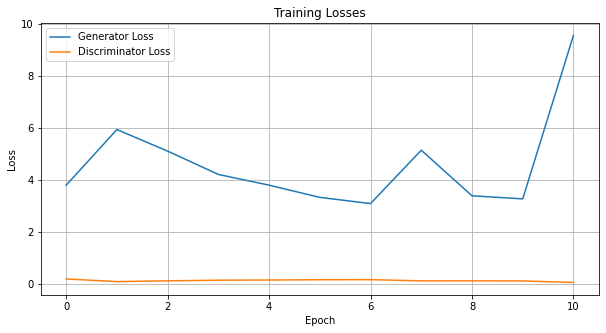

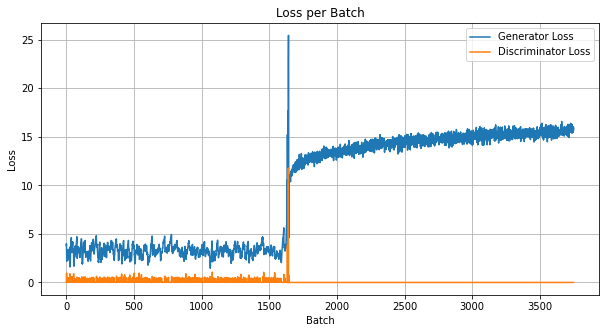

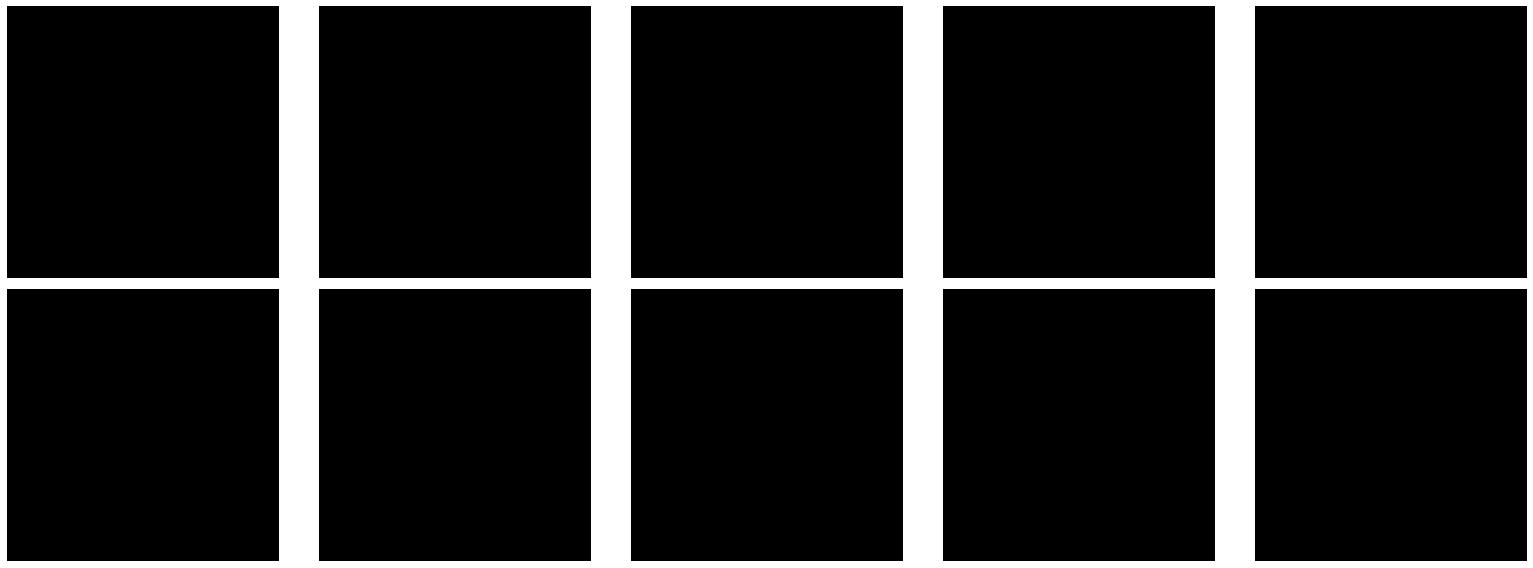

 47%|████▋     | 1753/3750 [05:30<06:04,  5.47it/s]

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

save_dir = '/kaggle/working/pesos_modelo_final_16_epocas/'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

generator_losses = []
discriminator_losses = []

np.random.seed(SEED)
for epoch in range(30):
    epoch_generator_loss = 0
    epoch_discriminator_loss = 0
    losses_per_batch = []  
    
    for batch in tqdm(range(STEPS_PER_EPOCH)):

        noise = np.random.normal(0,1, size=(BATCH_SIZE, NOISE_DIM))
        fake_X = generator.predict(noise)
        
        idx = np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)
        real_X = X_train[idx]

        X = np.concatenate((real_X, fake_X))

        disc_y = np.zeros(2*BATCH_SIZE)
        disc_y[:BATCH_SIZE] = 1

        d_loss = discriminator.train_on_batch(X, disc_y)
        
        y_gen = np.ones(BATCH_SIZE)
        g_loss = gan.train_on_batch(noise, y_gen)
        
        epoch_generator_loss += g_loss
        epoch_discriminator_loss += d_loss
        losses_per_batch.append((g_loss, d_loss))  

    
    epoch_generator_loss /= STEPS_PER_EPOCH
    epoch_discriminator_loss /= STEPS_PER_EPOCH
    
    generator_losses.append(epoch_generator_loss)
    discriminator_losses.append(epoch_discriminator_loss)

    print(f"EPOCH: {epoch + 1} Generator Loss: {epoch_generator_loss:.4f} Discriminator Loss: {epoch_discriminator_loss:.4f}")
    
    if (epoch + 1) % 2 == 0:
        
        print('Pesos guardados')
        generator.save_weights(os.path.join(save_dir, f"generator_weights_epoch_{epoch+1}.h5"))
        discriminator.save_weights(os.path.join(save_dir, f"discriminator_weights_epoch_{epoch+1}.h5"))
    
   
    plt.figure(figsize=(10, 5))
    plt.plot(generator_losses, label="Generator Loss")
    plt.plot(discriminator_losses, label="Discriminator Loss")
    plt.title("Training Losses")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    losses_per_batch = np.array(losses_per_batch)
    plt.figure(figsize=(10, 5))
    plt.plot(losses_per_batch[:, 0], label="Generator Loss")
    plt.plot(losses_per_batch[:, 1], label="Discriminator Loss")
    plt.title("Loss per Batch")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    noise = np.random.normal(0, 1, size=(10, NOISE_DIM))
    sample_images(noise, (2, 5))

In [ ]:
noise = np.random.normal(0, 1, size=(100, NOISE_DIM))
sample_images(noise, (10,10), (24,20), save=True)

In [ ]:
generated_images = generator.predict(noise)
generated_images.shape

In [ ]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(18,10))

sns.distplot(X_train, label='Real Images', hist=True, color='#fc0328', ax=axs)
sns.distplot(generated_images, label='Generated Images', hist=True, color='#0c06c7', ax=axs)

axs.legend(loc='upper right', prop={'size': 12})

plt.show()